In [0]:

from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt


In [0]:
path_csv = "/content/drive/My Drive/labeled.csv"
path_labeled_images = "/content/drive/My Drive/labeled"

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def extract_stars_28x28(image):

  """ Extracts stars from an image
    
  Detects all stars within the given image, extracts them and centers them within patches of size 28x28 with 
  a black background.
    
    
  Parameters
  ----------
  image : numpy.ndarray
    The image from which the stars are extracted. The image is assumed to be grayscale.
    
    
  Returns
  -------
  patches : list
    A list containing the resulting 28x28 patches.
        
  """
  
  _, image_binary = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)
  
  _, contours, _ = cv2.findContours(image_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    
  # tuples (x, y, w, h)
  bounding_rects = [cv2.boundingRect(c) for c in contours] 
  
  bounding_rects_filtered = [r for r in bounding_rects 
                             if not(r[0] <= 0 or r[0] + r[2] >= 1000 or r[1] <= 0 or r[1] + r[3] >= 1000)]
  
  patches = []
  
  for r in bounding_rects_filtered:
    
    x = r[0]; y = r[1]; w = r[2]; h = r[3]
    
    if(w > 28 or h > 28):
      continue
    
    star = image[y : y + h, x : x + w]
    
    if np.amax(star) < 30:
      continue
    
    patch = np.zeros((28, 28), dtype=np.float32)
    
    padding_y = (28 - h) // 2
    padding_x = (28 - w) // 2
    
    patch[padding_y : padding_y + h, padding_x : padding_x + w] = star
    
    patches.append(patch)
  
    
  return patches
  
  

In [0]:

import cv2


def load_labeled_images(path_csv, path_labeled_images):
    
    try:
        csv_file = open(path_csv, "r")

        list_id_label = [] # contains string tuples (id, label)

        for line in csv_file:
            if not "Id,Actual" in line:
                line = line.rstrip() # remove trailing newline character            
                list_id_label.append(line.split(","))

        list_id_label = sorted(list_id_label)

        labels = np.zeros(len(list_id_label)) # contains labels

        for idx, elem in enumerate(list_id_label):
            labels[idx] = float(elem[1])

        list_filenames = [] # contains filenames of images

        for filename in os.listdir(path_labeled_images):
            if filename.endswith(".png") and not filename.startswith("."):
                list_filenames.append(filename)

        list_filenames = sorted(list_filenames)

        assert len(labels) == len(list_filenames)

        # i suppose an image needs approximately
        # sizeof(np.float32) * 1 * 1000 * 1000 B of RAM

        # a list works well in terms of performance
        images = [] # images
        mirror_images = [] # mirror images
        
                
        for idx, filename in enumerate(list_filenames):
            
            if labels[idx] == 1.0: # include only images with label == 1.0
      
      
                img = cv2.imread(os.path.join(path_labeled_images, filename), cv2.IMREAD_GRAYSCALE)
    
                patches = extract_stars_28x28(img)
      
      
                for p in patches:
          
                  p = p.reshape((28, 28, 1))
                  p = np.divide(p, 255.0)
                  
                  images.append(p)
                  
        
        # conversion allows for batches to be extracted
        return np.stack(images)

    except Error:
        print("error: failed to load dataset.")

        

In [0]:

all_images = load_labeled_images(path_csv, path_labeled_images) # note: consider augment=True

print(all_images.shape)


(6259, 28, 28, 1)


In [0]:

num_images = len(all_images)
print(num_images)

frac_train = 0.9

num_images_train = int(num_images * frac_train)
num_images_test = num_images - num_images_train
print(num_images_train)
print(num_images_test)

batch_size = 100 # HYPERPARAMETER !!!

train_dataset = tf.data.Dataset.from_tensor_slices(all_images[:num_images_train, :, :, :]).shuffle(num_images_train).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(all_images[num_images_train:, :, :, :]).shuffle(num_images_test).batch(batch_size)


6259
5633
626


In [0]:

def get_num_parameters(model):
  
  total = 0
  for var in model.trainable_weights:
    total += tf.size(var)
  
  return total


In [0]:

class VAE(tf.keras.Model):
  
  def __init__(self, latent_dim):
    super(VAE, self).__init__()
    
    self.latent_dim = latent_dim
    
    self.inference_net = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(500, activation=None),
            tf.keras.layers.BatchNormalization(momentum=0.99),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(latent_dim + latent_dim) 
        ]
    )
        
    self.generative_net = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(500, activation=None),
            tf.keras.layers.BatchNormalization(momentum=0.99),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dense(28 * 28 * 1, activation=None),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1))
        ]
    )
    
    
  def encode(self, x):
    
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    
    return mean, logvar

  
  def decode(self, z, apply_sigmoid=False):

    logits = self.generative_net(z)
    
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits
  
  
  def reparameterize(self, mean, logvar):
    
    eps = tf.random.normal(shape=mean.shape)
    
    return eps * tf.exp(logvar * .5) + mean
  
  
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
      
    return self.decode(eps)
  
  def save_ckpt_generative(self, path):
    self.generative_net.save_weights(path)
      
  
  def load_ckpt_generative(self, path):
    self.generative_net.load_weights(path)
  
  

In [0]:

KL_div_mean = tf.keras.metrics.Mean('KL_div_mean', dtype=tf.float32)

logpx_z_mean = tf.keras.metrics.Mean('logpx_z_mean', dtype=tf.float32)


def KL_divergence(mean, logvar, raxis=1):
  
  return tf.reduce_sum(-0.5 * (1 + logvar - mean ** 2 - tf.exp(logvar)), axis=raxis)


def compute_loss(model, x, annealing):
  
  mean, logvar = model.encode(x)
  
  z = model.reparameterize(mean, logvar)
  
  x_logit = model.decode(z)
  
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  
  KL_div = KL_divergence(mean, logvar)
  
  # NOTE: TensorBoard summaries
  logpx_z_mean(logpx_z)
  KL_div_mean(KL_div)
  
  # NOTE: negation causes ascent -> descent
  # NOTE: reduce mean is expectation over batch of data
  return -tf.reduce_mean(logpx_z - annealing * KL_div)


# note: TensorFlow 2.0 optimization procedure
def compute_gradients(model, x, annealing):
  
  with tf.GradientTape() as tape:
    
    loss = compute_loss(model, x, annealing)
  
  return tape.gradient(loss, model.trainable_variables)


def apply_gradients(optimizer, gradients, variables):
  
  optimizer.apply_gradients(zip(gradients, variables))
  
  

In [0]:

optimizer = tf.keras.optimizers.Adadelta(lr=1)

epochs = 60

latent_dim = 16 # NOTE: dimension of latent space (bad quality if too small)


# instantiate model
model = VAE(latent_dim) 


def compute_annealing(epoch, epochs):
  
  frac = float(epoch) / float(epochs)
  
  c1 = 20.0
  c2 = 0.5
  
  return 1.0 / (1.0 + tf.exp(-c1 * (frac - c2)))


for epoch in range(1, epochs + 1):
    
  annealing = compute_annealing(epoch, epochs)
  
  for x in train_dataset:
    
    gradients = compute_gradients(model, x, annealing)
    apply_gradients(optimizer, gradients, model.trainable_variables)    
    
  if epoch % 5 == 0:  
    print("Done with epoch {}.".format(epoch))
  
    template = 'KL divergence (train) {}, Reconstr. error (train): {}'
    print (template.format(KL_div_mean.result(), logpx_z_mean.result()))

  # reset metrics
  KL_div_mean.reset_states()
  logpx_z_mean.reset_states()
  
  for x in test_dataset:
    
    compute_loss(model, x, annealing)
    
  if epoch % 5 == 0:  
    print("done with epoch {}".format(epoch))
  
    template = 'KL divergence (test) {}, Reconstr. error (test): {}'
    print (template.format(KL_div_mean.result(), logpx_z_mean.result()))

  # reset metrics
  KL_div_mean.reset_states()
  logpx_z_mean.reset_states()  



Done with epoch 5.
KL divergence (train) 76.57270050048828, Reconstr. error (train): -22.091337203979492
done with epoch 5
KL divergence (test) 77.08435821533203, Reconstr. error (test): -21.065641403198242
Done with epoch 10.
KL divergence (train) 69.5169677734375, Reconstr. error (train): -21.344833374023438
done with epoch 10
KL divergence (test) 66.31262969970703, Reconstr. error (test): -20.4805850982666
Done with epoch 15.
KL divergence (train) 43.84096908569336, Reconstr. error (train): -21.072134017944336
done with epoch 15
KL divergence (test) 41.35405349731445, Reconstr. error (test): -20.24997901916504
Done with epoch 20.
KL divergence (train) 17.53263282775879, Reconstr. error (train): -21.12388801574707
done with epoch 20
KL divergence (test) 17.172574996948242, Reconstr. error (test): -20.37071418762207
Done with epoch 25.
KL divergence (train) 5.969232559204102, Reconstr. error (train): -21.369613647460938
done with epoch 25
KL divergence (test) 5.56985330581665, Reconst

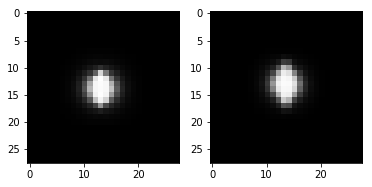

In [0]:

from PIL import Image


x = all_images[537, :, :, :].reshape((28, 28))

x_img = Image.fromarray((x * 255).astype(np.uint8), mode='L')


mean, logvar = model.encode(x.reshape(1, 28, 28, 1)) 
  
z = model.reparameterize(mean, logvar)
  
x_logit = model.decode(z)

x_logit_img = Image.fromarray((np.array(tf.sigmoid(x_logit)).reshape(28, 28) * 255).astype(np.uint8), mode='L')


_, axarr = plt.subplots(1, 2)
axarr[0].imshow(x_img, cmap='gray', vmin=0, vmax=255)
axarr[1].imshow(x_logit_img, cmap='gray', vmin=0, vmax=255)


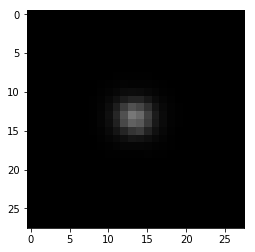

In [0]:

samples_logits = model.sample()

sample = Image.fromarray((np.array(tf.sigmoid(samples_logits[30, :, :, :])).reshape(28, 28) * 255).astype(np.uint8), 
                         mode='L')

plt.imshow(sample, cmap='gray', vmin=0, vmax=255)


In [0]:

from random import randint

dir_gen_images = "/content/drive/My Drive/generated_colab/"


def save_gen_images(dir_gen_images, n):
  
  for i in range(n):
    
    samples_logits = model.sample()
    
    j = randint(0, 99)

    sample = Image.fromarray(
        (np.array(tf.sigmoid(samples_logits[j, :, :, :])).reshape(28, 28) * 255).astype(np.uint8), mode='L')
            
    sample.save(dir_gen_images + "image" + str(i) + ".png", "png")
  
  
save_gen_images(dir_gen_images, 100)
